# This is a practice notebook for debugging issues with the astrotog package. 

In [1]:
import numpy as np
import sncosmo
from math import inf
from astropy.cosmology import Planck15 as cosmo
from astrotog import transient_obs_dist as tod
import matplotlib.pyplot as plt
from copy import deepcopy

## Define the general file paths and parameters

### Survey and SED file paths

In [2]:
surveydb_path = '/Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db'
fields = ['fieldID', 'fieldRA', 'fieldDec', 'filter', 'expMJD', 'fiveSigmaDepth']
db_flag = 'wfd'
sedsdb_path = "../sedb/rosswog/NSNS/winds"
gen_flag = 'cycle'

In [27]:
param_priors = {'zmin': 0.0, 'zmax': 0.1, 'cosmology': cosmo,
                'kappa_min': 1, 'kappa_max': 10, 'm_ej_min': 0.01,
                'm_ej_max': 0.2, 'v_ej_min': 0.01, 'v_ej_max': 0.5}
instrument_params = {'FOV_rad': np.deg2rad(1.75), 'Mag_Sys': 'ab', 'Instrument': 'lsst'}
Cuts = {'SNR': {'upper': inf, 'lower': 5}}
z0 = 0.00000225975 #redshift of 10pc for purpose of placing the SEDs
z1 = 1.0

## Get the SEDs from the provided data files and create data construct

In [4]:
sed_db = tod.Get_SEDdb(sedsdb_path)

### Get a small subset (one sed) to work with and debug with

In [5]:
test_sed = {}
test_key = 'SED_wind16'
test_model = deepcopy(sed_db[test_key]['model'])
test_sed[test_key] = deepcopy(sed_db[test_key])

In [6]:
lsst_bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

### Plot some of the lightcurves of this SED to get an idea of what's going on

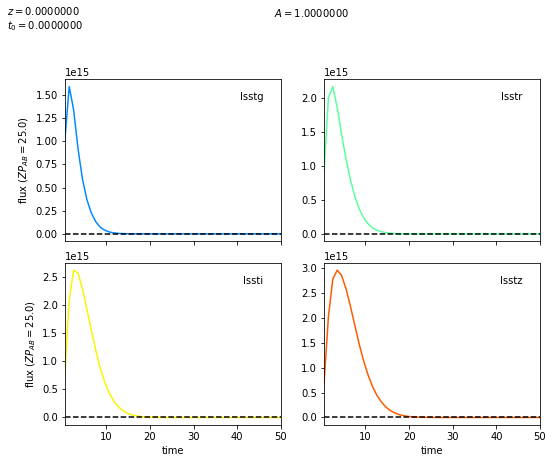

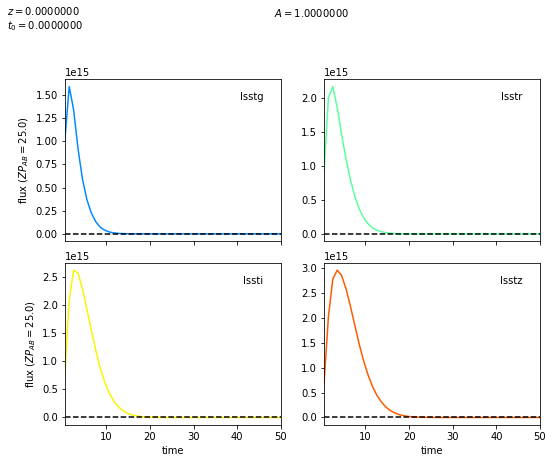

In [7]:
sncosmo.plot_lc(model = test_sed[test_key]['model'], bands = lsst_bands)

### Setup the wavelengths and time for SED comparison before and after redshifting

In [8]:
wavelengths = np.linspace(test_model.minwave()+1000,test_model.maxwave()-1000,100)
time_red_compare = 3.0

### Output a flux to compare with .dat file to make sure data is read in correctly

In [9]:
pre_z_flux = deepcopy(test_model.flux(time_red_compare,wavelengths))

In [10]:
R_Abs_Mag = deepcopy(test_model.bandmag('lsstr','ab',time_red_compare))

## Begin to investigate how setting the redshift affects the model and flux/amplitudes

In [11]:
test_model_only_z = deepcopy(test_sed[test_key]['model'])
test_model_only_z.set(z = z1)
test_sed_z_and_amp = deepcopy(tod.Set_SED_Redshift(test_sed, [z1],cosmo))

In [12]:
post_z_flux_only_z = deepcopy(test_model_only_z.flux(time_red_compare, wavelengths))
post_z_flux_both = deepcopy(test_sed_z_and_amp[test_key]['model'].flux(time_red_compare,wavelengths))

### Plot new lightcurves and plot the fluxes from the different redshifting methods

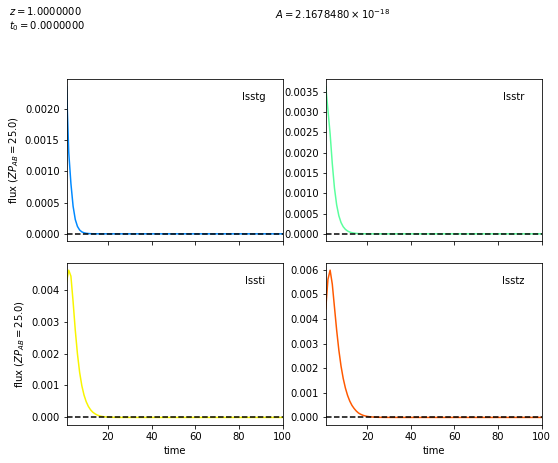

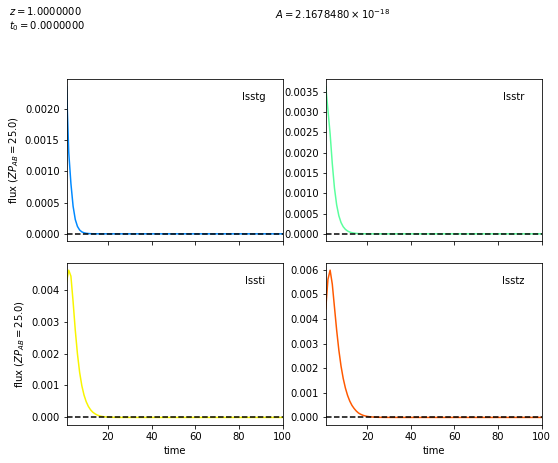

In [13]:
sncosmo.plot_lc(model = test_sed[test_key]['model'], bands = lsst_bands)

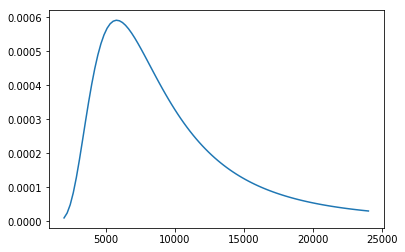

In [14]:
plt.plot(wavelengths,pre_z_flux)

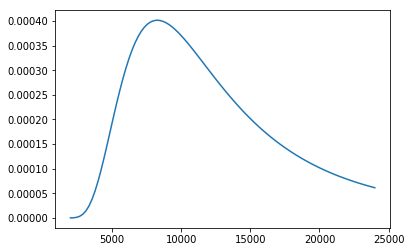

In [15]:
plt.plot(wavelengths,post_z_flux_only_z)

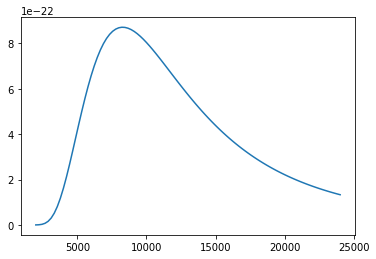

In [16]:
plt.plot(wavelengths,post_z_flux_both)

In [17]:
test_model.bandmag('lsstr','ab',time_red_compare)

-13.279670967614825

## Do the apparent magnitude calculation manually to compare the output from the code

In [18]:
lum_dist_Mpc = cosmo.luminosity_distance(z1).value
lum_dist_pc = lum_dist_Mpc * 1e6

In [19]:
R_app_mag_straightforward = R_Abs_Mag + 5*np.log10(lum_dist_pc) - 5
R_app_mag_code_both = test_sed_z_and_amp[test_key]['model'].bandmag('lsstr','ab',time_red_compare)
R_app_mag_code_z = test_model_only_z.bandmag('lsstr','ab',time_red_compare)
R_app_mag_code_z_plus_shift = R_app_mag_code_z + 5*np.log10(lum_dist_pc) - 5
print(R_app_mag_straightforward,R_app_mag_code_z, R_app_mag_code_both, R_app_mag_code_z_plus_shift)

30.8802569392 -12.6406014374 31.5193264694 31.5193264694


### Something odd seems to be happening with how sncosmo sets the magnitude

In [20]:
cosmo.distmod(z1).value + R_app_mag_code_z

31.519326469376736

# With the magnitude issues resolved move forward with placing the SEDs

In [21]:
tsed_z = test_sed_z_and_amp

### Get the survey database and paramters

In [22]:
obs_database = tod.Get_ObsStratDB_Summary(surveydb_path, db_flag)
survey_params = tod.Get_Survey_Params(obs_database)

 reading from database sqlite:////Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db
SELECT * FROM Summary WHERE PROPID in (54)


### Using the z-placed SED from above put the test_SED at a RA, Dec, and MJD within the survey

In [23]:
key_list = tsed_z.keys()
N_SEDs = len(tsed_z)
RA_dist, Dec_dist = tod.Ra_Dec_Dist(N_SEDs, survey_params)
t_dist = tod.Time_Dist(N_SEDs, survey_params)
for i, key in enumerate(key_list):
    tsed_z[key]['parameters']['z'] = tsed_z[key]['model'].get('z')
    tsed_z[key]['parameters']['ra'] = RA_dist[i]
    tsed_z[key]['parameters']['dec'] = Dec_dist[i]
    tsed_z[key]['parameters']['min_MJD'] = t_dist[i]
    tsed_z[key]['parameters']['max_MJD'] = t_dist[i] + tsed_z[key]['model'].maxtime()

In [24]:
print(tsed_z[key]['parameters'])

{'kappa': 1.0, 'm_ej': 0.2, 'v_ej': 0.05, 'z': 1.0, 'ra': 2.8726285849064448, 'dec': -0.05060189249864807, 'min_MJD': 60999.626956327782, 'max_MJD': 61099.626956327782}


### With this single SED try to use the generate observations functions

In [35]:
print(' Getting the LSST throughputs and computing the reference fluxes...')
instrument_params = tod.Get_Throughputs(instrument_params)
instrument_params = tod.Get_Reference_Flux(instrument_params)
print(' Done computing instrument parameters.')
print(instrument_params)

 Getting the LSST throughputs and computing the reference fluxes...
 Done computing instrument parameters.
{'FOV_rad': 0.030543261909900768, 'Mag_Sys': 'ab', 'Instrument': 'lsst', 'throughputs': {'lssti': {'wavelengths': array([  3000.,   3001.,   3002., ...,  11498.,  11499.,  11500.]), 'throughput': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, 'lssty': {'wavelengths': array([  3000.,   3001.,   3002., ...,  11498.,  11499.,  11500.]), 'throughput': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, 'lsstz': {'wavelengths': array([  3000.,   3001.,   3002., ...,  11498.,  11499.,  11500.]), 'throughput': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, 'lsstu': {'wavelengths': array([  3000.,   3001.,   3002., ...,  11498.,  11499.,  11500.]), 'throughput': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, 'lsstg': {'wavelengths': array([  3000.,   3001.,   3002., ...,  11498.,  11499.,  11500.]), 'throughput': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, 'lsstr': {'wavelengths': array([  3000.,   3

In [29]:
All_Source_Observations = tod.Gen_Observations(tsed_z, obs_database, instrument_params)
print(All_Source_Observations)

{'SED_wind16': {'model': <sncosmo.models.Model object at 0x1a20b63940>, 'parameters': {'kappa': 1.0, 'm_ej': 0.2, 'v_ej': 0.05, 'z': 1.0, 'ra': 2.8726285849064448, 'dec': -0.05060189249864807, 'min_MJD': 60999.626956327782, 'max_MJD': 61099.626956327782}, 'observations': {'lsstz': {'times': array([ 61010.347826,  61015.337191,  61015.34809 ,  61036.346873,
        61036.359904,  61099.136473,  61099.152759]), 'magnitudes': [array([ 32.54019619]), array([ 34.2552602]), array([ 34.25961083]), array([ 44.0839026]), array([ 44.091327]), array([ 99.0573795]), array([ 99.07440376])], 'mag_errors': [6855167825.726302, 35911644734.78803, 34874592803.28698, 256646563426719.78, 255569848436649.72, 1.5119304526878762e+36, 1.4567489723797987e+36]}, 'lssty': {'times': array([ 61024.348722,  61024.351404,  61028.340341,  61028.347056,
        61030.345483,  61042.279649,  61071.180382,  61072.199539]), 'magnitudes': [array([ 36.54469577]), array([ 36.54580169]), array([ 38.1960819]), array([ 38.1987

In [30]:
print(All_Source_Observations[test_key]['observations'].keys())

dict_keys(['lsstz', 'lssty', 'lsstu', 'lsstg', 'lsstr', 'lssti'])


In [31]:
All_Source_Observations[test_key]['observations']['lssty']

{'mag_errors': [1024051848932.6024,
  1018950567130.8923,
  3937440470862.4956,
  3892610732429.4883,
  7985440826931.939,
  2773945723020755.5,
  1.8955847205181026e+23,
  3.5239497537475375e+23],
 'magnitudes': [array([ 36.54469577]),
  array([ 36.54580169]),
  array([ 38.1960819]),
  array([ 38.19872534]),
  array([ 39.07183714]),
  array([ 45.0952988]),
  array([ 64.9466179]),
  array([ 65.77949717])],
 'times': array([ 61024.348722,  61024.351404,  61028.340341,  61028.347056,
         61030.345483,  61042.279649,  61071.180382,  61072.199539])}

In [32]:
All_Source_Observations[test_key]['model'].bandmag('lssty','ab',100)

91.431543261681014

In [33]:
All_Source_Observations = tod.Assign_SNR(All_Source_Observations)

In [34]:
All_Source_Observations[test_key]['observations']['lssty']['magnitudes']

{'SNR': array([[  3.56863725e-11,   3.58650330e-11,   9.28133290e-12,
           9.38822253e-12,   4.57641557e-12,   1.31742649e-14,
           1.92788512e-22,   1.03703794e-22],
        [  3.56874525e-11,   3.58661184e-11,   9.28161377e-12,
           9.38850663e-12,   4.57655407e-12,   1.31746636e-14,
           1.92794346e-22,   1.03706932e-22],
        [  3.72989726e-11,   3.74857065e-11,   9.70073889e-12,
           9.81245866e-12,   4.78321520e-12,   1.37695852e-14,
           2.01500263e-22,   1.08389973e-22],
        [  3.73015540e-11,   3.74883008e-11,   9.70141025e-12,
           9.81313775e-12,   4.78354623e-12,   1.37705381e-14,
           2.01514208e-22,   1.08397474e-22],
        [  3.81541591e-11,   3.83451743e-11,   9.92315628e-12,
           1.00374376e-11,   4.89288419e-12,   1.40852926e-14,
           2.06120237e-22,   1.10875126e-22],
        [  4.40361480e-11,   4.42566109e-11,   1.14529474e-11,
           1.15848468e-11,   5.64718965e-12,   1.62567344e-14,
       

### Try to compute the SNR without the np.divide

In [41]:
mags = np.vstack(All_Source_Observations[test_key]['observations']['lssty']['magnitudes'])
errors = np.vstack(All_Source_Observations[test_key]['observations']['lssty']['mag_errors'])
np.divide(mags,errors)

array([[  3.56863725e-11],
       [  3.58661184e-11],
       [  9.70073889e-12],
       [  9.81313775e-12],
       [  4.89288419e-12],
       [  1.62567344e-14],
       [  3.42620497e-22],
       [  1.86664118e-22]])